# Tutorial for Creating a Model
[PyBaMM/examples/notebooks/Creating Models at develop · pybamm-team/PyBaMM](https://github.com/pybamm-team/PyBaMM/tree/develop/examples/notebooks/Creating%20Models)

## ODE Model

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt


## Define Model

In [2]:
model = pybamm.BaseModel()

## Define Variables

In [3]:
x = pybamm.Variable("x")
y = pybamm.Variable("y")

In [4]:
dxdt = 4*x-2*y
dydt = 3*x-1*y

## Define RHS and Initial Conditions

In [5]:
model.rhs = {x: dxdt, y: dydt}

In [6]:
model.initial_conditions={x: pybamm.Scalar(1),y: pybamm.Scalar(2)}

In [7]:
model.variables = {"x": x, "y": y, "z": x + 4 * y}

## Discretize

In [8]:
disc = pybamm.Discretisation()  # use the default discretisation
disc.process_model(model);

## Solve

In [9]:
solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 20)
solution = solver.solve(model, t)

In [10]:
t_sol, y_sol = solution.t, solution.y  # get solution times and states
x = solution["x"]  # extract and process x from the solution
y = solution["y"]  # extract and process y from the solution

In [11]:
len(y_sol[1,:])

20

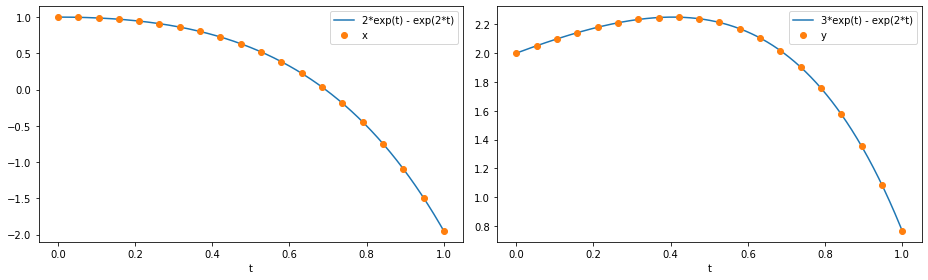

In [12]:
t_fine = np.linspace(0, t[-1], 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.plot(t_fine, 2 * np.exp(t_fine) - np.exp(2 * t_fine), t_sol, x(t_sol), "o")
ax1.set_xlabel("t")
ax1.legend(["2*exp(t) - exp(2*t)", "x"], loc="best")

ax2.plot(t_fine, 3 * np.exp(t_fine) - np.exp(2 * t_fine), t_sol, y(t_sol), "o")
ax2.set_xlabel("t")
ax2.legend(["3*exp(t) - exp(2*t)", "y"], loc="best")

plt.tight_layout()
plt.show()

## PDE Model

Problem of linear diffusion on a unit sphere,
\begin{equation*}
  \frac{\partial c}{\partial t} = \nabla \cdot (\nabla c),
\end{equation*}
with the following boundary and initial conditions:
\begin{equation*}
  \left.\frac{\partial c}{\partial r}\right\vert_{r=0} = 0, \quad \left.\frac{\partial c}{\partial r}\right\vert_{r=1} = 2, \quad \left.c\right\vert_{t=0} = 1.
\end{equation*}


In [13]:
model = pybamm.BaseModel()

c = pybamm.Variable("Concentration", domain="negative particle")

In [14]:
N = -pybamm.grad(c)  # define the flux
dcdt = -pybamm.div(N)  # define the rhs equation

model.rhs = {c: dcdt}  # add the equation to rhs dictionary

In [15]:
# initial conditions
model.initial_conditions = {c: pybamm.Scalar(1)}

# boundary conditions
lbc = pybamm.Scalar(0)
rbc = pybamm.Scalar(2)
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}}

In [16]:
model.variables = {"Concentration": c, "Flux": N}

In [17]:
# define geometry
r = pybamm.SpatialVariable(
    "r", domain=["negative particle"], coord_sys="spherical polar"
)
geometry = {"negative particle": {r: {"min": pybamm.Scalar(0), "max": pybamm.Scalar(1)}}}

In [18]:
# mesh and discretise
submesh_types = {"negative particle": pybamm.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

In [19]:
spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

2022-04-21 09:20:08,381 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative particle. Using default of 1 [m].


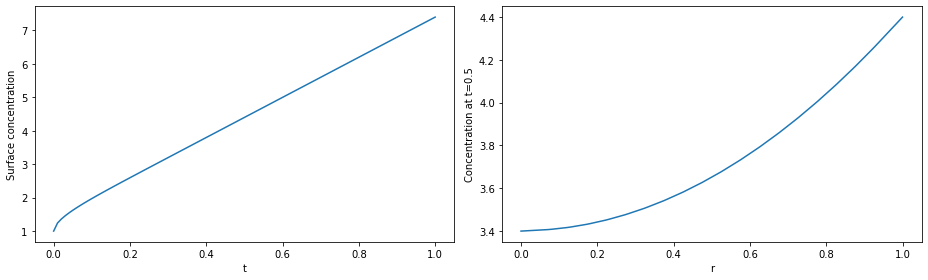

In [20]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 1, 100)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c(solution.t, r=1))
ax1.set_xlabel("t")
ax1.set_ylabel("Surface concentration")
r = np.linspace(0, 1, 100)
ax2.plot(r, c(t=0.5, r=r))
ax2.set_xlabel("r")
ax2.set_ylabel("Concentration at t=0.5")
plt.tight_layout()
plt.show()

# Negative Particle Example

problem of spherical diffusion in the negative electrode particle within the single particle model:
\begin{equation*}
  \frac{\partial c}{\partial t} = \nabla \cdot (D \nabla c),
\end{equation*}
with the following boundary and initial conditions:
\begin{equation*}
  \left.\frac{\partial c}{\partial r}\right\vert_{r=0} = 0, \quad \left.\frac{\partial c}{\partial r}\right\vert_{r=R} = -\frac{j}{FD}, \quad \left.c\right\vert_{t=0} = c_0,
\end{equation*}
where $c$ is the concentration, $r$ the radial coordinate, $t$ time, $R$ the particle radius, $D$ the diffusion coefficient, $j$ the interfacial current density, $F$ Faraday's constant, and $c_0$ the initial concentration. 

In [21]:
# Initialize Model 
model = pybamm.BaseModel()

# Define Parameters
R = pybamm.Parameter("Particle radius [m]")
D = pybamm.Parameter("Diffusion coefficient [m2.s-1]")
j = pybamm.Parameter("Interfacial current density [A.m-2]")
F = pybamm.Parameter("Faraday constant [C.mol-1]")
c0 = pybamm.Parameter("Initial concentration [mol.m-3]")

# Define Variable
c = pybamm.Variable("Concentration [mol.m-3]", domain="negative particle")

In [22]:
# governing equations
N = -D * pybamm.grad(c)  # flux
dcdt = -pybamm.div(N)
model.rhs = {c: dcdt}  

# boundary conditions 
lbc = pybamm.Scalar(0)
rbc = -j / F / D
model.boundary_conditions = {c: {"left": (lbc, "Neumann"), "right": (rbc, "Neumann")}}

# initial conditions 
model.initial_conditions = {c: c0}

In [23]:
model.variables = {
    "Concentration [mol.m-3]": c,
    "Surface concentration [mol.m-3]": pybamm.surf(c),
    "Flux [mol.m-2.s-1]": N,
}

In [24]:
param = pybamm.ParameterValues(
    {
        "Particle radius [m]": 10e-6,
        "Diffusion coefficient [m2.s-1]": 3.9e-14,
        "Interfacial current density [A.m-2]": 1.4,
        "Faraday constant [C.mol-1]": 96485,
        "Initial concentration [mol.m-3]": 2.5e4,
    }
)

In [25]:
r = pybamm.SpatialVariable("r", domain=["negative particle"], coord_sys="spherical polar")
geometry = {"negative particle": {r: {"min": pybamm.Scalar(0), "max": R}}}

In [26]:
param.process_model(model)
param.process_geometry(geometry)

In [27]:
submesh_types = {"negative particle": pybamm.Uniform1DSubMesh}
var_pts = {r: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {"negative particle": pybamm.FiniteVolume()}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model);

2022-04-21 09:27:49,696 - [WARNING] processed_variable.get_spatial_scale(520): No length scale set for negative particle. Using default of 1 [m].


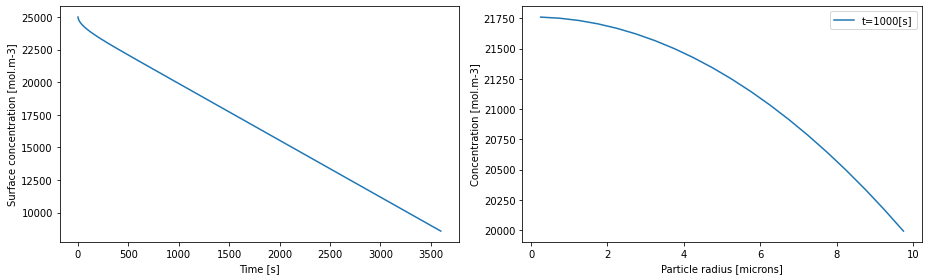

In [28]:
# solve
solver = pybamm.ScipySolver()
t = np.linspace(0, 3600, 600)
solution = solver.solve(model, t)

# post-process, so that the solution can be called at any time t or space r
# (using interpolation)
c = solution["Concentration [mol.m-3]"]
c_surf = solution["Surface concentration [mol.m-3]"]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(solution.t, c_surf(solution.t))
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Surface concentration [mol.m-3]")

r = mesh["negative particle"].nodes # radial position
time = 1000  # time in seconds
ax2.plot(r * 1e6, c(t=time, r=r), label="t={}[s]".format(time))
ax2.set_xlabel("Particle radius [microns]")
ax2.set_ylabel("Concentration [mol.m-3]")
ax2.legend()

plt.tight_layout()
plt.show()